# CNN + 標準化

## 載入套件

In [1]:
import os
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split
from torchmetrics import Accuracy
from torchvision import transforms
from torchvision.datasets import MNIST

## 設定參數

In [2]:
# 設定參數
PATH_DATASETS = "" # 預設路徑
BATCH_SIZE = 1024  # 批量
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
"cuda" if torch.cuda.is_available() else "cpu"

'cuda'

## 步驟1：載入 MNIST 手寫阿拉伯數字資料

In [3]:
transform=transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.1307,), std=(0.3081,))
    ])

# 下載 MNIST 手寫阿拉伯數字 訓練資料
train_ds = MNIST(PATH_DATASETS, train=True, download=True, 
                 transform=transform)

# 下載測試資料
test_ds = MNIST(PATH_DATASETS, train=False, download=True, 
                 transform=transform)

# 訓練/測試資料的維度
print(train_ds.data.shape, test_ds.data.shape)

torch.Size([60000, 28, 28]) torch.Size([10000, 28, 28])


## 步驟2：資料清理，此步驟無需進行

## 步驟3：進行特徵工程，將特徵縮放成(0, 1)之間

In [4]:
# train_ds.data = train_ds.data / 255.0
# test_ds.data = test_ds.data / 255.0

## 步驟4：資料分割，此步驟無需進行，載入MNIST資料時，已經切割好了

## 步驟5：建立模型結構

In [5]:
import math

# W, F, P, S：image Width, Filter width, Padding, Stride 
# def Conv_Width(W, F, P, S):
#     return math.floor(((W - F) + 2 * P) / S) + 1

# # def Pool_Width(W, F, S):
#     return math.floor((W - F) / S) + 1

def Conv_Width(W, F, P, S):
    return math.floor(((W - F + 2 * P) / S) + 1)

def Conv_Output_Volume(W, F, P, S, out):
    return Conv_Width(W, F, P, S) ** 2 * out

# C: no of channels
def Conv_Parameter_Count(F, C, out):
    return F ** 2 * C * out

def Pool_Width(W, F, P, S):
    return Conv_Width(W, F, P, S)

# filter_count: no of filter in last conv 
# stride count default value = Filter width
def Pool_Output_Volume(W, F, P, S, filter_count):
    return Conv_Output_Volume(W, F, P, S, filter_count)

def Pool_Parameter_Count(W, F, S):
    return 0

def Conv_Pool_Width(W, F, P, S, F2, P2, S2, n):
    for i in range(n):
        W = Pool_Width(Conv_Width(W, F, P, S), F2, P2, S2)
    return W

In [6]:
# ConvNet2
l2_Width = Conv_Width(Conv_Width(28, 3, 0, 1), 3, 0, 1)
p1_out = Pool_Output_Volume(l2_Width, 2, 0, 2, 64)
l2_Width, p1_out

(24, 9216)

## 步驟6：結合訓練資料及模型，進行模型訓練

In [7]:
# Conv2d 參數： in-channel, out-channel, kernel size, Stride, Padding
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [8]:
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    loss_list = []    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        
        optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if (batch_idx+1) % 10 == 0:
            loss_list.append(loss.item())
            batch = (batch_idx+1) * len(data)
            data_count = len(train_loader.dataset)
            percentage = (100. * (batch_idx+1) / len(train_loader))
            print(f'Epoch {epoch}: [{batch:5d} / {data_count}] ({percentage:.0f} %)' +
                  f'  Loss: {loss.item():.6f}')
    return loss_list

In [9]:
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    # 平均損失
    test_loss /= len(test_loader.dataset) 
    # 顯示測試結果
    data_count = len(test_loader.dataset)
    percentage = 100. * correct / data_count 
    print(f'平均損失: {test_loss:.4f}, 準確率: {correct}/{data_count}' + 
          f' ({percentage:.2f}%)\n')

In [10]:
epochs = 10
lr = 0.1

# 改變批量以縮短訓練時間
train_loader = DataLoader(train_ds, shuffle=True, batch_size=600)

# 建立模型
model = Net().to(device)

# 設定優化器(optimizer)
optimizer = torch.optim.Adadelta(model.parameters(), lr=lr)

loss_list = []
for epoch in range(1, epochs + 1):
    loss_list += train(model, device, train_loader, optimizer, epoch)
    #test(model, device, test_loader)
    optimizer.step()
    

Epoch 1: [ 6000 / 60000] (10 %)  Loss: 1.827908
Epoch 1: [12000 / 60000] (20 %)  Loss: 1.248245
Epoch 1: [18000 / 60000] (30 %)  Loss: 0.851046
Epoch 1: [24000 / 60000] (40 %)  Loss: 0.567789
Epoch 1: [30000 / 60000] (50 %)  Loss: 0.480891
Epoch 1: [36000 / 60000] (60 %)  Loss: 0.498269
Epoch 1: [42000 / 60000] (70 %)  Loss: 0.515344
Epoch 1: [48000 / 60000] (80 %)  Loss: 0.483743
Epoch 1: [54000 / 60000] (90 %)  Loss: 0.384602
Epoch 1: [60000 / 60000] (100 %)  Loss: 0.386423
Epoch 2: [ 6000 / 60000] (10 %)  Loss: 0.419692
Epoch 2: [12000 / 60000] (20 %)  Loss: 0.417465
Epoch 2: [18000 / 60000] (30 %)  Loss: 0.354337
Epoch 2: [24000 / 60000] (40 %)  Loss: 0.400533
Epoch 2: [30000 / 60000] (50 %)  Loss: 0.321174
Epoch 2: [36000 / 60000] (60 %)  Loss: 0.270999
Epoch 2: [42000 / 60000] (70 %)  Loss: 0.325577
Epoch 2: [48000 / 60000] (80 %)  Loss: 0.223223
Epoch 2: [54000 / 60000] (90 %)  Loss: 0.230614
Epoch 2: [60000 / 60000] (100 %)  Loss: 0.210260
Epoch 3: [ 6000 / 60000] (10 %)  Loss:

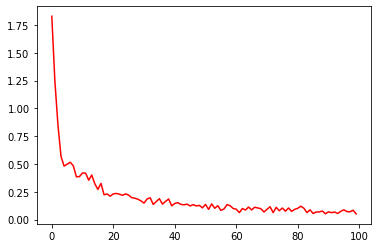

In [11]:
# 對訓練過程的損失繪圖
import matplotlib.pyplot as plt

plt.plot(loss_list, 'r')

## 步驟7：評分(Score Model)

In [12]:
# 建立 DataLoader
test_loader = DataLoader(test_ds, shuffle=False, batch_size=BATCH_SIZE)

# 評分
test(model, device, test_loader)

平均損失: 0.0439, 準確率: 9839/10000 (98.39%)



In [13]:
# 實際預測 20 筆資料
predictions = []
with torch.no_grad():
    for i in range(20):
        data, target = test_ds[i][0], test_ds[i][1]
        data = data.reshape(1, *data.shape).to(device)
        output = torch.argmax(model(data), axis=-1)
        predictions.append(str(output.item()))

# 比對
print('actual    :', test_ds.targets[0:20].numpy())
print('prediction: ', ' '.join(predictions[0:20]))

actual    : [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
prediction:  7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4


In [14]:
# 顯示第 9 筆的機率
import numpy as np

i=8
data = test_ds[i][0]
data = data.reshape(1, *data.shape).to(device)
print(data.shape)
predictions = torch.softmax(model(data), dim=1)
print(f'0~9預測機率: {np.around(predictions.cpu().detach().numpy(), 2)}')
print(f'0~9預測機率: {np.argmax(predictions.cpu().detach().numpy(), axis=-1)}')

torch.Size([1, 1, 28, 28])
0~9預測機率: [[0.   0.   0.   0.   0.   0.91 0.09 0.   0.   0.  ]]
0~9預測機率: [5]


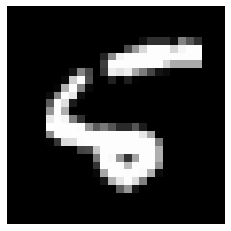

In [15]:
# 顯示第 9 筆圖像
X2 = test_ds[i][0] 
plt.imshow(X2.reshape(28,28), cmap='gray')
plt.axis('off')
plt.show() 

In [16]:
test_ds[i][0]

tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0

## 步驟8：評估，暫不進行

## 步驟9：模型佈署

In [17]:
# 模型存檔
torch.save(model, 'cnn_mnist_model.pth')

# 模型載入
model = torch.load('cnn_mnist_model.pth')

## 步驟10：新資料預測

In [18]:
# 使用小畫家，繪製 0~9，實際測試看看
from skimage import io
from skimage.transform import resize

no=7
uploaded_file = f'./myDigits/{no}.png'
image1 = io.imread(uploaded_file, as_gray=True)

# 縮為 (28, 28) 大小的影像
data_shape = data.shape
image_resized = resize(image1, data_shape[2:], anti_aliasing=True)    
X1 = image_resized.reshape(*data_shape) 

# 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
X1 = 1.0-X1

# 圖像轉換
X1 = (X1 - 0.1307) / 0.3081  

for i in range(X1[0][0].shape[0]):
    for j in range(X1[0][0].shape[1]):
        print(f'{X1[0][0][i][j]:.4f}', end=' ')
    print()

-0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 
-0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 
-0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 
-0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4241 -0.4238 -0.4240 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 
-0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4242 -0.4128 -0.2873 -0.1876 -0.2

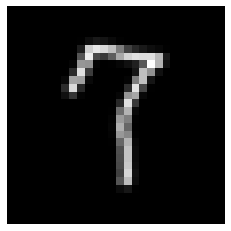

In [19]:
# 顯示第1張圖片圖像
import matplotlib.pyplot as plt

# 繪製點陣圖，cmap='gray':灰階
plt.imshow(X1.reshape(28,28), cmap='gray')

# 隱藏刻度
plt.axis('off') 

# 顯示圖形
plt.show() 

In [20]:
# 將非0的數字轉為1，顯示第1張圖片
X2 = X1[0][0].copy()
X2[X2>(0.1 + 0.1307) / 0.3081]=1 # 0.1 將淺色忽略
print(type(X2), X2[0].shape)
# 將轉換後二維內容顯示出來，隱約可以看出數字為 5
text_image=[]
for i in range(X2.shape[0]):
    text_image.append(''.join(X2[i].astype(int).astype(str)))
text_image

<class 'numpy.ndarray'> (28,)


['0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000111100000000000000',
 '0000000000100011111100000000',
 '0000000001100000001100000000',
 '0000000001000000011000000000',
 '0000000011000000010000000000',
 '0000000010000000100000000000',
 '0000000000000001100000000000',
 '0000000000000001000000000000',
 '0000000000000001000000000000',
 '0000000000000010000000000000',
 '0000000000000010000000000000',
 '0000000000000011000000000000',
 '0000000000000001000000000000',
 '0000000000000001000000000000',
 '0000000000000001000000000000',
 '0000000000000001000000000000',
 '0000000000000001000000000000',
 '0000000000000001000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000',
 '0000000000000000000000000000']

In [21]:
data_shape = X1.shape
data_shape

(1, 1, 28, 28)

In [22]:
X1 = torch.FloatTensor(X1).to(device)

# 預測
predictions = model(X1)
print(f'actual/prediction: {no} {np.argmax(predictions.detach().cpu().numpy())}')

actual/prediction: 7 7


In [23]:
model(X1)

tensor([[-5.9622, -1.9524, -3.2974, -2.3534, -5.0511, -4.1827, -6.3905, -0.6559,
         -4.3466, -1.7828]], device='cuda:0', grad_fn=<LogSoftmaxBackward0>)

In [24]:
# 讀取影像並轉為單色
for i in range(10):
    uploaded_file = f'./myDigits/{i}.png'
    image1 = io.imread(uploaded_file, as_gray=True)

    # 縮為 (28, 28) 大小的影像
    image_resized = resize(image1, data_shape[2:], anti_aliasing=True)    
    X1 = image_resized.reshape(*data_shape) 

    # 反轉顏色，顏色0為白色，與 RGB 色碼不同，它的 0 為黑色
    X1 = 1.0-X1
    
    # 圖像轉換
    X1 = (X1 - 0.1307) / 0.3081  
    
    X1 = torch.FloatTensor(X1).to(device)
    
    # 預測
    predictions = torch.softmax(model(X1), dim=1)
    # print(np.around(predictions.cpu().detach().numpy(), 2))
    print(f'actual/prediction: {i} {np.argmax(predictions.detach().cpu().numpy())}')

actual/prediction: 0 0
actual/prediction: 1 1
actual/prediction: 2 2
actual/prediction: 3 3
actual/prediction: 4 4
actual/prediction: 5 5
actual/prediction: 6 6
actual/prediction: 7 7
actual/prediction: 8 8
actual/prediction: 9 8
